# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from PIL import Image

/data/ephemeral/home/cherry/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Class

In [118]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        root_dir: str, 
        info_df: pd.DataFrame, 
        transform: Callable,
        is_inference: bool = False
    ):
        # 데이터셋의 기본 경로, 이미지 변환 방법, 이미지 경로 및 레이블을 초기화합니다.
        self.root_dir = root_dir  # 이미지 파일들이 저장된 기본 디렉토리
        self.transform = transform  # 이미지에 적용될 변환 처리
        self.is_inference = is_inference # 추론인지 확인
        self.image_paths = info_df['image_path'].tolist()  # 이미지 파일 경로 목록
        self.images=[None]*len(info_df)
        
        if not self.is_inference:
            self.targets = info_df['target'].tolist()  # 각 이미지에 대한 레이블 목록

    def __len__(self) -> int:
        # 데이터셋의 총 이미지 수를 반환합니다.
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        # 주어진 인덱스에 해당하는 이미지를 로드하고 변환을 적용한 후, 이미지와 레이블을 반환합니다.
        if self.images[index] is None:
            img_path = os.path.join(self.root_dir, self.image_paths[index])  # 이미지 경로 조합
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 BGR 컬러 포맷의 numpy array로 읽어옵니다.
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # BGR 포맷을 GRAY 포맷으로 변환합니다.
            self.images[index] = image
        else:
            image = self.images[index]
        
        if self.transform:
            image = self.transform(image)  # 설정된 이미지 변환을 적용합니다.
        else:
            pass
                
        if self.is_inference:
            return image
        else:
            target = self.targets[index]  # 해당 이미지의 레이블
            return image, target  # 변환된 이미지와 레이블을 튜플 형태로 반환합니다. 

# Transform Class

In [119]:
class TorchvisionTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 텐서 변환, 정규화
        common_transforms = [
            transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 리사이즈
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            transforms.Grayscale(num_output_channels=1),
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 색상 조정 추가
            self.transform = transforms.Compose(common_transforms +
                [
                    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    transforms.RandomRotation(15),  # 최대 15도 회전
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정,
                ] 
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = transforms.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환
        
        transformed = self.transform(image)  # 설정된 변환을 적용
        
        return transformed  # 변환된 이미지 반환

In [120]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485], std=[0.229]),  # 정규화
            ToTensorV2(),  # albumentations에서 제공하는 PyTorch 텐서 변환
            
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [   A.RandomCrop(224,224),
                    A.HorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=90),  # 최대 15도 회전  
                    A.RandomBrightnessContrast(p=0.5,c=0.5),# 밝기 및 대비 무작위 조정
                    A.GaussianBlur()
                    #A.ElasticTransform()
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")
        
        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용
        
        return transformed['image']  # 변환된 이미지의 텐서를 반환

In [121]:
class TransformSelector:
    """
    이미지 변환 라이브러리를 선택하기 위한 클래스.
    """
    def __init__(self, transform_type: str):

        # 지원하는 변환 라이브러리인지 확인
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type
        
        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):
        
        # 선택된 라이브러리에 따라 적절한 변환 객체를 생성
        if self.transform_type == 'torchvision':
            transform = TorchvisionTransform(is_train=is_train)
        
        elif self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)
        
        return transform

# Model Class

In [122]:
class TorchvisionModel(nn.Module):
    """
    Torchvision에서 제공하는 사전 훈련된 모델을 사용하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool
    ):
        super(TorchvisionModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=pretrained)
        
        # 모델의 최종 분류기 부분을 사용자 정의 클래스 수에 맞게 조정
        if 'fc' in dir(self.model):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        
        elif 'classifier' in dir(self.model):
            num_ftrs = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [123]:
class TimmModel(nn.Module):
    """
    Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool,
        in_chans: int
    ):
        super(TimmModel, self).__init__()
        self.model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=num_classes,
            in_chans=in_chans
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [124]:
class ModelSelector:
    """
    사용할 모델 유형을 선택하는 클래스.
    """
    def __init__(
        self, 
        model_type: str, 
        num_classes: int, 
        **kwargs
    ):
        
        # 모델 유형에 따라 적절한 모델 객체를 생성
        if model_type == 'torchvision':
            self.model = TorchvisionModel(num_classes=num_classes, **kwargs)
        
        elif model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)
        
        else:
            raise ValueError("Unknown model type specified.")

    def get_model(self) -> nn.Module:

        # 생성된 모델 객체 반환
        return self.model

# Loss Class

In [125]:
class Loss(nn.Module):
    """
    모델의 손실함수를 계산하는 클래스.
    """
    def __init__(self):
        super(Loss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(
        self, 
        outputs: torch.Tensor, 
        targets: torch.Tensor
    ) -> torch.Tensor:
    
        return self.loss_fn(outputs, targets)

# Model Training

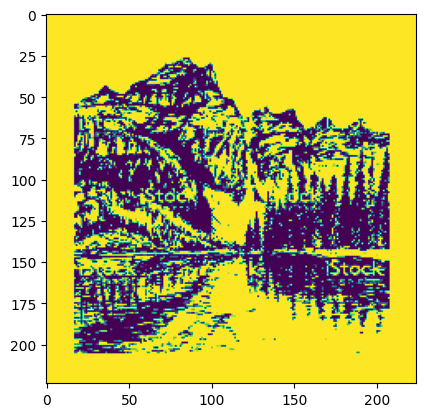

In [126]:
import matplotlib.pyplot as plt
plt.imshow(next(iter(train_loader),)[0][28].permute(1,2,0))

In [127]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
device

device(type='cuda')

In [129]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "../data/train"
traindata_info_file = "../data/train.csv"
save_result_path = "./train_result"

# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.

testdata_dir = "../data/test"
testdata_info_file = "../data/test.csv"
test_info = pd.read_csv(testdata_info_file)

In [130]:
import math
def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, min_lr=0):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        else:
            # Cosine annealing after warmup
            progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return max(cosine_decay, min_lr / optimizer.defaults['lr'])

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): 성능이 향상되지 않더라도 몇 에폭 동안 기다릴지 설정.
            min_delta (float): 성능 향상 최소 한계. 이보다 작은 변화는 무시.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # 성능이 향상되면 카운터를 초기화
        else:
            self.counter += 1  # 향상이 없으면 카운터 증가
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
class model3(nn.Module):
    def __init__(self,num_classes,):
        model_selector = ModelSelector(
            model_type='timm', 
            num_classes=num_classes,
            model_name='resnet18', 
            pretrained=True,
            in_chans=1
            )
        
        model = model_selector.get_model().to(device)

In [131]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

n_splits=3
batch_size=64
loss_fn = Loss()
num_epochs=20
num_classes=500

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)

train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)
test_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_info,
    transform=None,
    #augmentation=augmented_transform,
    #is_train=True
)

test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=None,
    is_inference=True,
)

early_stopping = EarlyStopping(patience=5, min_delta=0.001)
predicts = torch.zeros((len(test_dataset),500))


for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
    # 학습에 사용할 Model을 선언.
    model_selector = ModelSelector(
                model_type='timm', 
                num_classes=num_classes,
                model_name='resnet18', 
                pretrained=True,
                in_chans=1
                )
        
    model = model_selector.get_model().to(device)

    
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

 # Train/Validation Subset 생성
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    # Train과 Validation에 각각 다른 transforms 적용
    train_subset.dataset.transform = train_transform  # augmentation 적용
    val_subset.dataset.transform = val_transform      # augmentation 미적용
    
    # DataLoader 생성
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # 스케줄러 초기화
    scheduler_step_size = 30  # 매 30step마다 학습률 감소
    scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

    # 한 epoch당 step 수 계산
    steps_per_epoch = len(train_loader)

    # 2 epoch마다 학습률을 감소시키는 스케줄러 선언
    epochs_per_lr_decay = 3
    scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

    # Warmup settings
    warmup_steps = 500  # Number of steps for warmup
    total_steps = 15 * len(train_loader)  # Total training steps

    #scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)


    for epoch in range(num_epochs):
            model.train()
            running_loss, correct = 0.0,0
            progress_bar = tqdm(train_loader, desc="Training", leave=False)
            for images, targets in progress_bar:
                images, targets = images.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                scheduler.step()
                running_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
                correct += torch.sum(outputs.argmax(1) == targets).item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, accuracy: {(100*correct/len(train_loader.dataset))}')

            # 검증
            model.eval()
            val_loss,correct = 0.0,0
            correct = 0
            total = 0
            progress_bar = tqdm(val_loader, desc="Validating", leave=False)

            with torch.no_grad():
                for images, labels in progress_bar:
                    images, labels = images.to(device),labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    progress_bar.set_postfix(loss=loss.item())
                    correct += torch.sum(outputs.argmax(1) == labels).item()
                early_stopping(val_loss)
            
            print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {(100*correct/len(val_loader.dataset)):.2f}%')

            # 가장 낮은 validation loss 모델 저장
            if epoch > 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()  # 모델의 상태 저장
                    best_model_path = os.path.join(save_result_path, '/best_model_{}.pt'.format(fold))
                    torch.save(best_model_state, best_model_path)
                    print(f"Best model saved with validation loss: {best_val_loss/len(val_loader):.4f}")
                else:
                    pass
            else: 
                best_val_loss = val_loss

    # 가장 낮은 validation loss를 기록한 모델 불러오기
    best_model = model_selector.get_model()
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()  # inference 모드로 설정
    
    test_dataset.transform = test_transform
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=False)

    correct = 0
    total = 0

    progress_bar = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for i,images in enumerate(progress_bar):
            images= images.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)
            predicts[i * batch_size:(i + 1) * batch_size] += probs.cpu().numpy()  # 확률값 더하기

    print('{}_test_finish'.format(fold))

final_preds = np.argmax(predicts,axis=1)

Epoch [1/20], Loss: 5.108202454390799, accuracy: 10.225684042340722


Validation Loss: 3.4499, Validation Accuracy: 26.34%


Epoch [2/20], Loss: 2.1831769548403988, accuracy: 50.77890952666267


Validation Loss: 2.1873, Validation Accuracy: 47.29%
Best model saved with validation loss: 2.1873


Epoch [3/20], Loss: 1.0122157498529762, accuracy: 76.2332734172159


Validation Loss: 1.7467, Validation Accuracy: 56.74%
Best model saved with validation loss: 1.7467


Epoch [4/20], Loss: 0.4403415459925961, accuracy: 92.42061114439784


Validation Loss: 1.4647, Validation Accuracy: 63.93%
Best model saved with validation loss: 1.4647


Epoch [5/20], Loss: 0.3340232509906125, accuracy: 95.67605352506492


Validation Loss: 1.4320, Validation Accuracy: 64.77%
Best model saved with validation loss: 1.4320


Epoch [6/20], Loss: 0.28834293687799173, accuracy: 96.58478130617137


Validation Loss: 1.4114, Validation Accuracy: 65.21%
Best model saved with validation loss: 1.4114


Epoch [7/20], Loss: 0.25253858991489286, accuracy: 97.5534252047134


Validation Loss: 1.4131, Validation Accuracy: 65.07%


Epoch [8/20], Loss: 0.25153072918676267, accuracy: 97.50349510685041


Validation Loss: 1.4085, Validation Accuracy: 65.31%
Best model saved with validation loss: 1.4085


Epoch [9/20], Loss: 0.2459301490123105, accuracy: 97.79308967445576


Validation Loss: 1.4059, Validation Accuracy: 65.05%
Best model saved with validation loss: 1.4059


Epoch [10/20], Loss: 0.24148358015497778, accuracy: 97.86299181146396


Validation Loss: 1.4088, Validation Accuracy: 65.31%


Epoch [11/20], Loss: 0.2403097194471177, accuracy: 97.90293588975435


Validation Loss: 1.4066, Validation Accuracy: 65.15%


Epoch [12/20], Loss: 0.24145235700212467, accuracy: 97.96285200718994


Validation Loss: 1.4096, Validation Accuracy: 65.23%


Epoch [13/20], Loss: 0.24163430521062984, accuracy: 97.78310365488316


Validation Loss: 1.4026, Validation Accuracy: 65.47%
Best model saved with validation loss: 1.4026


Epoch [14/20], Loss: 0.23907691164381184, accuracy: 97.76313161573796


Validation Loss: 1.4042, Validation Accuracy: 65.27%


Epoch [15/20], Loss: 0.23863454077653823, accuracy: 97.89294987018175


Validation Loss: 1.4031, Validation Accuracy: 65.53%


Epoch [16/20], Loss: 0.24059373529473688, accuracy: 97.84301977231875


Validation Loss: 1.4045, Validation Accuracy: 65.27%


KeyboardInterrupt: 

# Inference

In [132]:
val_imgs,val_labels = next(iter(val_loader))
val_imgs,val_labels  = val_imgs.to(device), val_labels.to(device)

In [133]:
outputs = model(val_imgs)

In [134]:
print(outputs.shape,val_labels.shape)

torch.Size([64, 500]) torch.Size([64])


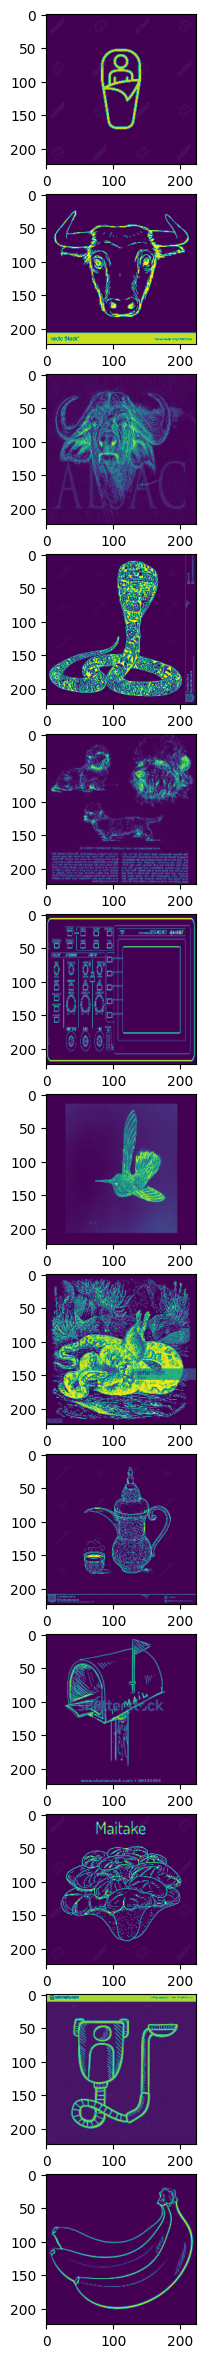

In [135]:
fig,axes = plt.subplots(13,1,figsize=(150,30))

for n,i in enumerate(val_imgs[outputs.argmax(1) == val_labels][:13]):
    axes[n].imshow(i.cpu().permute(1,2,0))

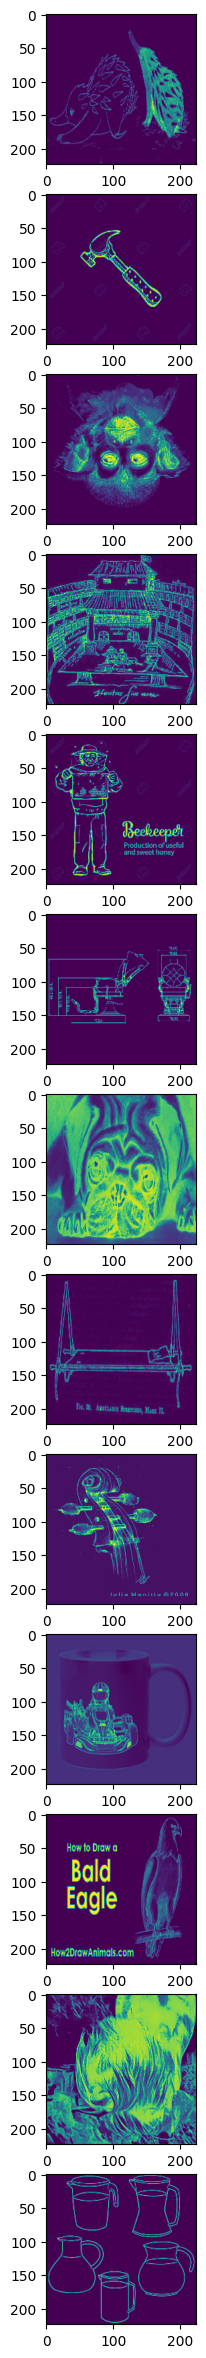

In [136]:
fig,axes = plt.subplots(13,1,figsize=(150,30))

for n,i in enumerate(val_imgs[outputs.argmax(1) != val_labels][:13]):
    axes[n].imshow(i.cpu().permute(1,2,0))

In [66]:
labels.shape

torch.Size([60])

In [61]:
outputs.argmax(1) == labels

RuntimeError: The size of tensor a (30) must match the size of tensor b (60) at non-singleton dimension 0

In [113]:
len(final_preds)

10014

In [56]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = final_preds
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,314
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,213
10011,10011,10011.JPEG,219
10012,10012,10012.JPEG,277


In [58]:
# DataFrame 저장
test_info.to_csv("./submissions/ss_output_0917_2_efficientv2_kfold_adamw.csv", index=False)